--- Initial Data ---
DataFrame shape: (7095, 3)
         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

--- Data with 'has_mask' column ---
         ImageId  ClassId                                      EncodedPixels  \
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...   
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...   
4  0014fce06.jpg        3  229501 11 229741 33 229981

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


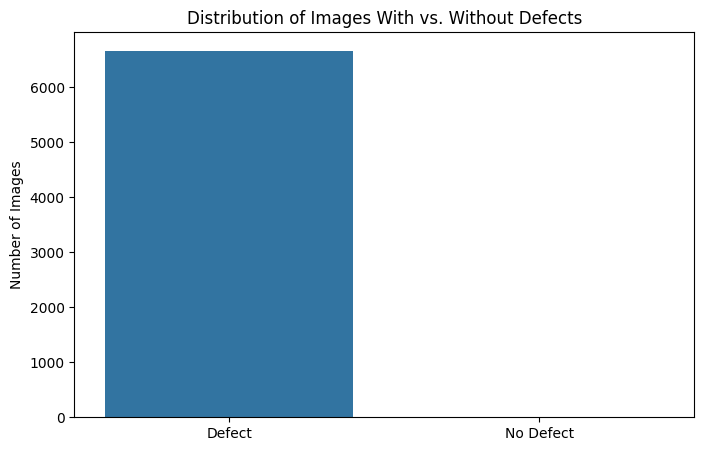


--- Defect Class Distribution ---
ClassId
1     897
2     247
3    5150
4     801
Name: count, dtype: int64


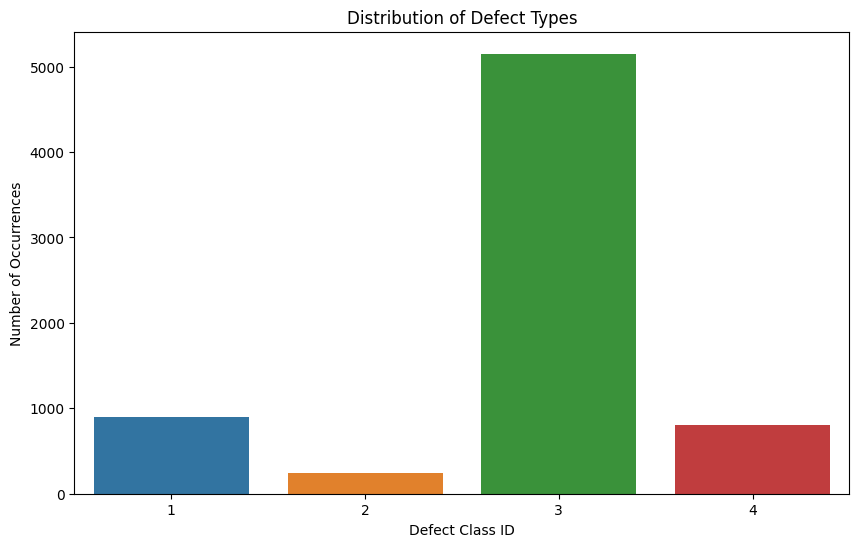


--- Pivoted DataFrame (One Row Per Image) ---
Pivoted DataFrame shape: (6666, 6)
         ImageId                                             mask_1 mask_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...    NaN   
1  0007a71bf.jpg                                                NaN    NaN   
2  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...    NaN   
3  000f6bf48.jpg                                                NaN    NaN   
4  0014fce06.jpg                                                NaN    NaN   

                                              mask_3  \
0                                                NaN   
1  18661 28 18863 82 19091 110 19347 110 19603 11...   
2                                                NaN   
3                                                NaN   
4  229501 11 229741 33 229981 55 230221 77 230468...   

                                              mask_4  total_defects  
0                                         

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data and Initial Setup ---

DATA_DIR = '/kaggle/input/severstal-steel-defect-detection/'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')

# Load the training data
df = pd.read_csv(TRAIN_CSV_PATH)

print("--- Initial Data ---")
print(f"DataFrame shape: {df.shape}")
print(df.head())

# --- 2. Data Preparation ---
# The data is already in a good format. We just need to add a 'has_mask' column.
# The 'EncodedPixels' will be NaN if there is no defect of that ClassId for that ImageId.
df['has_mask'] = ~df['EncodedPixels'].isna()

# Ensure ClassId is an integer for proper plotting and indexing
df['ClassId'] = df['ClassId'].astype(int)

print("\n--- Data with 'has_mask' column ---")
print(df.head())


# --- 3. Exploratory Data Analysis (EDA) ---

# How many unique images are in the dataset?
# We need to create a temporary dataframe that only has one row per image to count this accurately.
image_df = df.groupby('ImageId')['has_mask'].any().reset_index()
num_images = len(image_df)
print(f"\nTotal unique images: {num_images}")

# How many images have at least one defect?
images_with_defects = image_df['has_mask'].sum()
print(f"Images with at least one defect: {images_with_defects}")
print(f"Images with NO defects: {num_images - images_with_defects}")

# Plotting the distribution of images with and without defects
plt.figure(figsize=(8, 5))
sns.barplot(x=['Defect', 'No Defect'], y=[images_with_defects, num_images - images_with_defects])
plt.title('Distribution of Images With vs. Without Defects')
plt.ylabel('Number of Images')
plt.show()


# What is the distribution of the 4 defect types?
defect_counts = df[df['has_mask'] == True]['ClassId'].value_counts().sort_index()
print("\n--- Defect Class Distribution ---")
print(defect_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=defect_counts.index, y=defect_counts.values)
plt.title('Distribution of Defect Types')
plt.xlabel('Defect Class ID')
plt.ylabel('Number of Occurrences')
plt.show()


# --- 4. Pivot the DataFrame ---
# The most useful format for modeling is one row per image, with columns for each defect's mask.
# We will pivot the table to achieve this structure.

# Note: The original df has multiple rows for a single image if it has multiple defects.
# We need to handle this. We'll use the first non-null mask for each class, which is what pivot does.
df_pivot = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
df_pivot.columns = [f'mask_{col}' for col in df_pivot.columns]

# Create a 'total_defects' column
df_pivot['total_defects'] = df_pivot.notna().sum(axis=1)

# Reset index to make 'ImageId' a regular column, which is often easier to work with
df_pivot = df_pivot.reset_index()


print("\n--- Pivoted DataFrame (One Row Per Image) ---")
print(f"Pivoted DataFrame shape: {df_pivot.shape}")
print(df_pivot.head())

--- Visualizing images with their defect masks ---


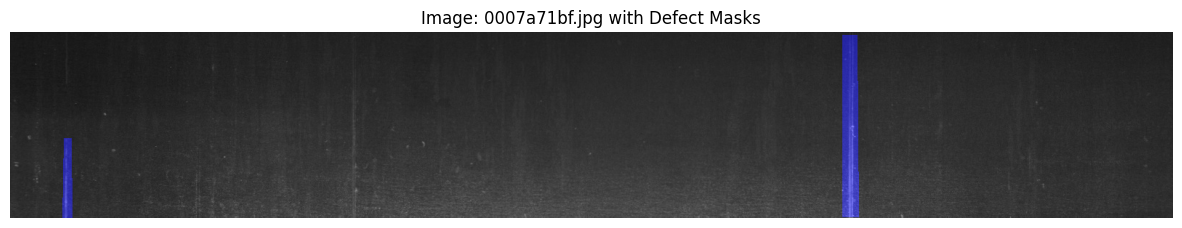

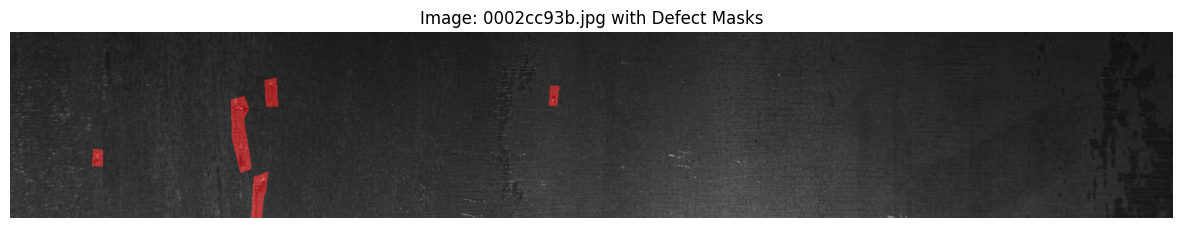

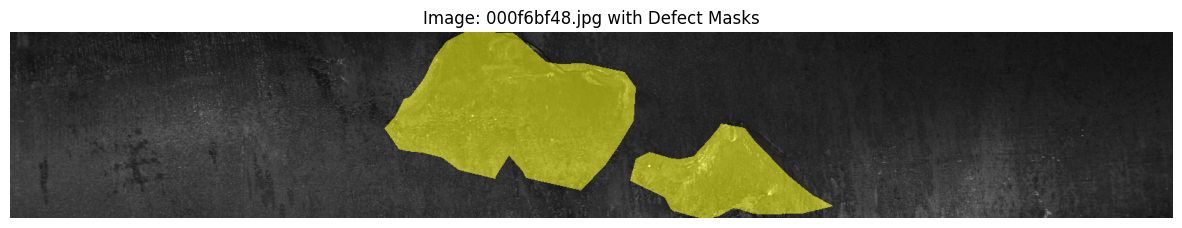


Visualizing an image with multiple defects: 0025bde0c.jpg


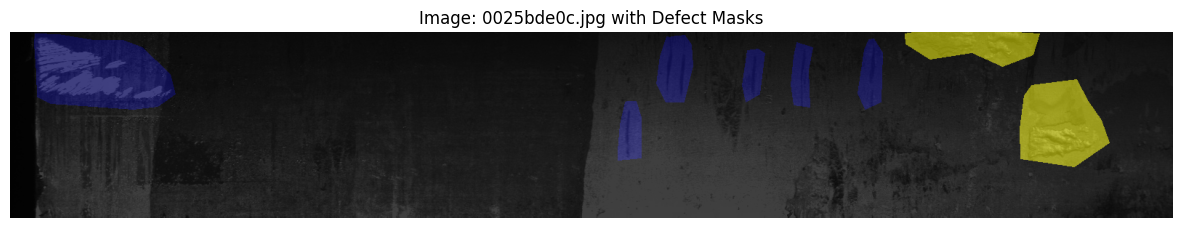

In [5]:
import cv2 # OpenCV for image handling

# --- 1. Helper Functions for Mask Decoding ---

# Function to decode a single run-length encoding (RLE) string into a binary mask
def rle2mask(rle_string, height=256, width=1600):
    '''
    rle_string: a string of space-separated numbers
    height, width: dimensions of the image
    Returns a 2D numpy array of 0s and 1s
    '''
    # If the RLE string is empty (NaN), return an empty mask
    if pd.isna(rle_string):
        return np.zeros((height, width), dtype=np.uint8)

    # Split the RLE string into a list of numbers
    rle_numbers = [int(num) for num in rle_string.split(' ')]
    
    # Get the pixel start and length pairs
    pixel_starts = np.array(rle_numbers[::2]) - 1 # RLE is 1-indexed, Python is 0-indexed
    pixel_lengths = np.array(rle_numbers[1::2])
    
    # Create an empty mask array
    mask = np.zeros(height * width, dtype=np.uint8)
    
    # Set the corresponding pixels to 1
    for start, length in zip(pixel_starts, pixel_lengths):
        mask[start:start+length] = 1
        
    # Reshape the mask to the image dimensions.
    # Note: RLE is encoded in 'Fortran' (column-major) order.
    mask = mask.reshape((height, width), order='F')
    
    return mask

# Function to build a 4-channel mask for a single image
def build_masks(image_id, df_pivoted):
    '''
    image_id: The ID of the image (e.g., '0002cc93b.jpg')
    df_pivoted: The pivoted dataframe we created
    Returns a (height, width, 4) numpy array where each channel corresponds to a defect class
    '''
    # Get the row corresponding to the image_id
    row = df_pivoted[df_pivoted['ImageId'] == image_id]
    if row.empty:
        return np.zeros((256, 1600, 4), dtype=np.uint8)
        
    # Extract the RLE strings for each of the 4 mask types
    rle_masks = row[['mask_1', 'mask_2', 'mask_3', 'mask_4']].iloc[0]
    
    # Decode each RLE string and stack them into a single 4-channel array
    all_masks = np.stack([rle2mask(rle) for rle in rle_masks], axis=-1)
    
    return all_masks


# --- 2. Main Visualization Function ---

def show_image_with_masks(image_id, df_pivoted):
    '''
    Loads an image, builds its masks, and displays them overlaid on the image.
    '''
    # Load the original image
    img_path = os.path.join(TRAIN_IMG_DIR, image_id)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert for matplotlib
    
    # Build the 4-channel mask for this image
    masks = build_masks(image_id, df_pivoted)
    
    # Define colors for each defect type (B, G, R, Y)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    
    # Overlay each mask
    for i in range(4):
        # Check if the mask for this class has any pixels
        if masks[:, :, i].sum() > 0:
            # Create a colored overlay
            # np.dstack creates a 3-channel color image from the binary mask
            overlay = np.dstack([masks[:, :, i] * color for color in colors[i]])
            # Use imshow with transparency (alpha) to overlay the mask
            plt.imshow(overlay, alpha=0.5, label=f'Class {i+1}')

    plt.title(f'Image: {image_id} with Defect Masks')
    plt.axis('off')
    plt.show()


# --- 3. Visualize Some Examples ---

print("--- Visualizing images with their defect masks ---")

# Example 1: An image with a defect of type 3
show_image_with_masks('0007a71bf.jpg', df_pivot)

# Example 2: An image with a defect of type 1
show_image_with_masks('0002cc93b.jpg', df_pivot)

# Example 3: An image with a defect of type 4
show_image_with_masks('000f6bf48.jpg', df_pivot)

# Find and display an image with multiple defects
multi_defect_example = df_pivot[df_pivot['total_defects'] > 1].iloc[0]
print(f"\nVisualizing an image with multiple defects: {multi_defect_example['ImageId']}")
show_image_with_masks(multi_defect_example['ImageId'], df_pivot)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- 1. Define the Custom PyTorch Dataset (Corrected) ---

class SteelDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None):
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_ids = df['ImageId'].tolist()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        img_path = os.path.join(self.data_dir, image_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        masks = build_masks(image_id, self.df) # This creates a (256, 1600, 4) numpy array
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # FIX IS HERE:
        # After augmentations, the mask is a Tensor of shape (H, W, C).
        # We must explicitly permute it to (C, H, W) for PyTorch.
        # We also convert its type to float for the loss function.
        masks = masks.permute(2, 0, 1).to(torch.float32)
        
        return image, masks

# --- 2. Define Augmentations ---
IMG_HEIGHT = 256
IMG_WIDTH = 800

train_transforms = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.95, 1.05), translate_percent=0.05, rotate=(-15, 15), p=0.5),
    A.CoarseDropout(max_holes=8, max_height=int(IMG_HEIGHT*0.1), max_width=int(IMG_WIDTH*0.1), min_holes=1, fill_value=0, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(), # This converts image to tensor and scales pixels.
])

val_transforms = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# --- 3. Split Data and Create DataLoaders ---
train_df, val_df = train_test_split(df_pivot, test_size=0.1, random_state=42)

train_dataset = SteelDataset(df=train_df, data_dir=TRAIN_IMG_DIR, transforms=train_transforms)
val_dataset = SteelDataset(df=val_df, data_dir=TRAIN_IMG_DIR, transforms=val_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- 4. Verify a Batch ---
images, masks = next(iter(train_loader))

print("\n--- Verifying a single batch (Corrected) ---")
print(f"Images batch shape: {images.shape}")
print(f"Masks batch shape: {masks.shape}")
print(f"Images dtype: {images.dtype}")
print(f"Masks dtype: {masks.dtype}")

/tmp/ipykernel_494/3907258111.py:49: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=int(IMG_HEIGHT*0.1), max_width=int(IMG_WIDTH*0.1), min_holes=1, fill_value=0, p=0.5),



--- Verifying a single batch (Corrected) ---
Images batch shape: torch.Size([4, 3, 256, 800])
Masks batch shape: torch.Size([4, 4, 256, 800])
Images dtype: torch.float32
Masks dtype: torch.float32


--- Generating one clear example for each defect class for verification ---

VERIFYING ==> Class 1: Pitting / Dots
Showing image: 0002cc93b.jpg


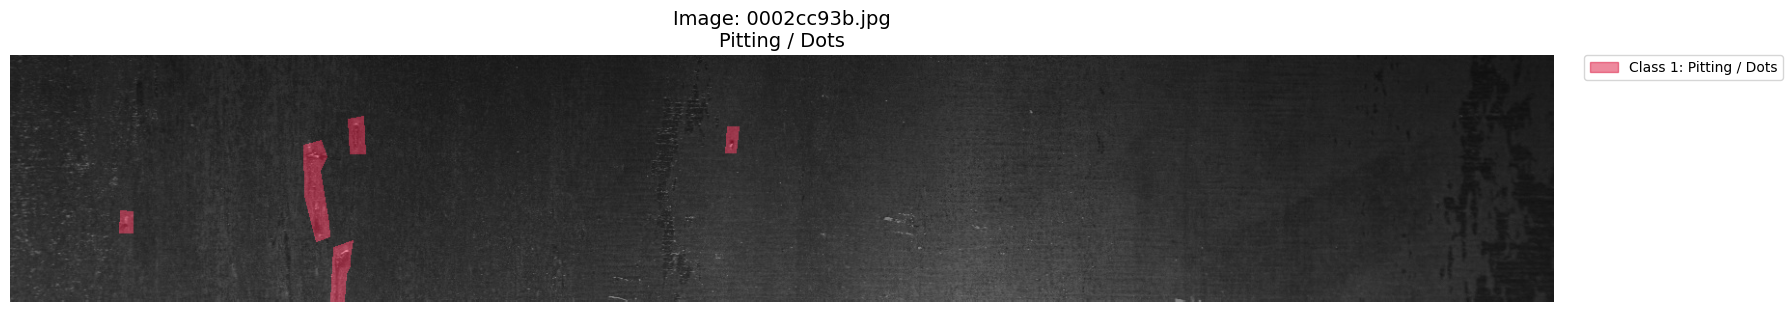


VERIFYING ==> Class 2: Fine Vertical Lines
Showing image: 026183d85.jpg


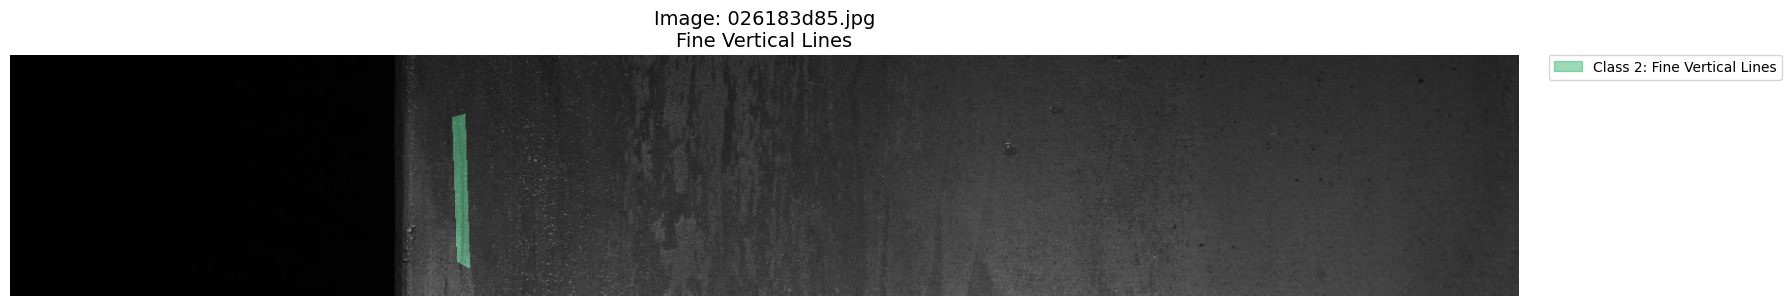


VERIFYING ==> Class 3: Scratches / Abrasions
Showing image: 0007a71bf.jpg


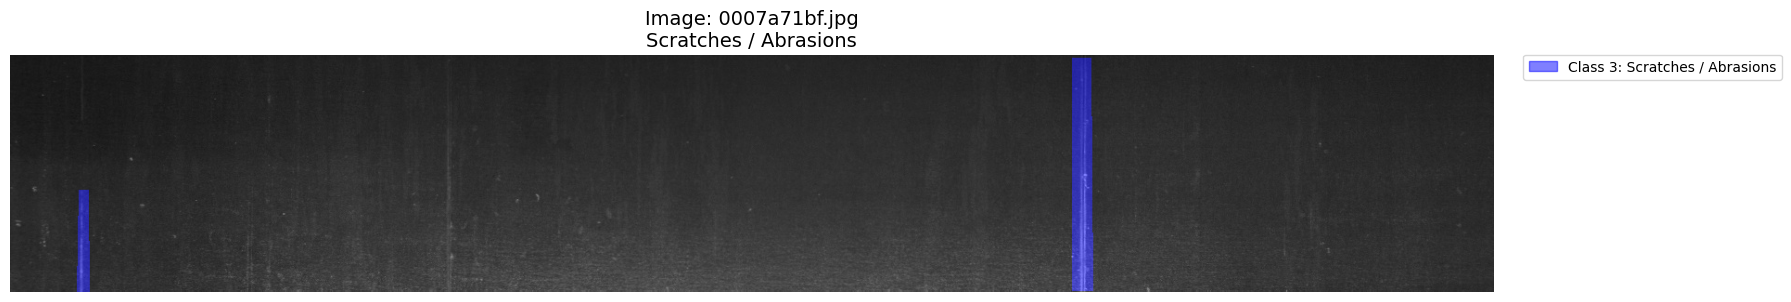


VERIFYING ==> Class 4: Surface Patches
Showing image: 000f6bf48.jpg


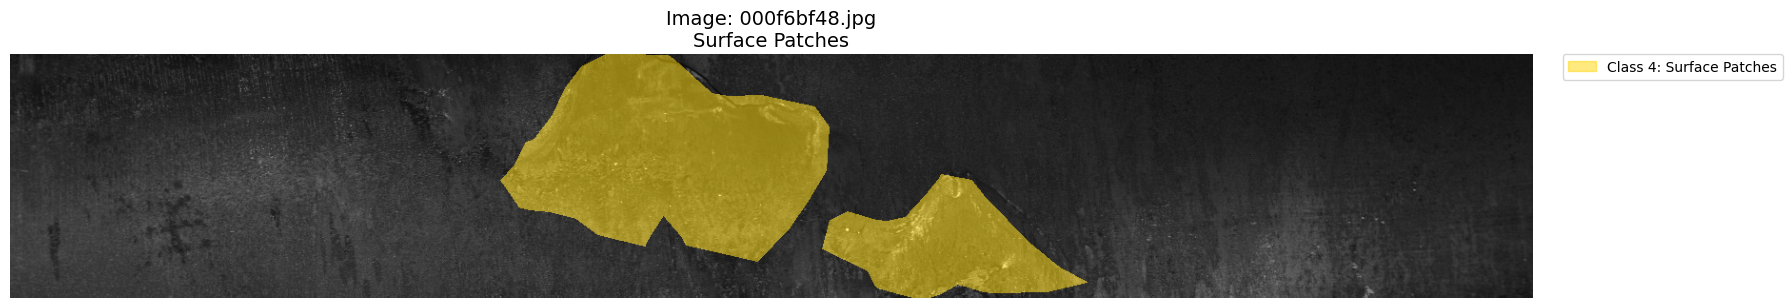

In [7]:
# --- 1. Finalized Class Names and Visualization Function ---

CLASS_NAMES = {
    1: "Pitting / Dots",
    2: "Fine Vertical Lines",
    3: "Scratches / Abrasions",
    4: "Surface Patches"
}

def show_image_with_labeled_masks(image_id, df_pivoted):
    img_path = os.path.join(TRAIN_IMG_DIR, image_id)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = build_masks(image_id, df_pivoted)
    colors = [(220, 20, 60), (60, 179, 113), (0, 0, 255), (255, 215, 0)] # Crimson, MedSeaGreen, Blue, Gold
    
    plt.figure(figsize=(18, 8))
    plt.imshow(image)
    
    legend_elements = []
    title_parts = [f'Image: {image_id}']
    
    for i in range(4):
        class_id = i + 1
        if masks[:, :, i].sum() > 0:
            title_parts.append(CLASS_NAMES[class_id])
            overlay = np.dstack([masks[:, :, i] * color for color in colors[i]])
            plt.imshow(overlay, alpha=0.5)
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, color=[c/255 for c in colors[i]], alpha=0.5, 
                                                 label=f"Class {class_id}: {CLASS_NAMES[class_id]}"))

    plt.title('\n'.join(title_parts), fontsize=14)
    if legend_elements:
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- 2. Systematic Verification Loop ---
# We will now loop through each class and show one clear example.
# We specifically look for images that ONLY have one type of defect to avoid confusion.

print("--- Generating one clear example for each defect class for verification ---")

for class_id in range(1, 5):
    print("\n" + "="*50)
    print(f"VERIFYING ==> Class {class_id}: {CLASS_NAMES[class_id]}")
    
    # Find images that ONLY have a defect of the current class_id
    candidate_df = df_pivot[(df_pivot[f'mask_{class_id}'].notna()) & (df_pivot['total_defects'] == 1)]
    
    if not candidate_df.empty:
        # Select the first example
        example_id = candidate_df.iloc[0]['ImageId']
        print(f"Showing image: {example_id}")
        show_image_with_labeled_masks(example_id, df_pivot)
    else:
        print(f"Could not find an image with ONLY a Class {class_id} defect.")

In [8]:
!pip install -q segmentation-models-pytorch

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from tqdm import tqdm
import os # Import the os module to check for files

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

print("Defining a U-Net model with EfficientNet-B4 backbone...")
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4,
).to(DEVICE)

dice_loss = smp.losses.DiceLoss(mode='multilabel')
focal_loss = smp.losses.FocalLoss(mode='multilabel')
total_loss = lambda pred, target: 0.5 * dice_loss(pred, target) + 0.5 * focal_loss(pred, target)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

NUM_EPOCHS = 15
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    loop = tqdm(loader, desc="Training")
    running_loss = 0.0
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def validate_one_epoch(loader, model, loss_fn, device):
    model.eval()
    loop = tqdm(loader, desc="Validating")
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
    return running_loss / len(loader)

MODEL_SAVE_PATH = "best_model_advanced.pth"
best_val_loss = float('inf')


if os.path.exists(MODEL_SAVE_PATH):
    print(f"Found saved model at {MODEL_SAVE_PATH}. Loading weights...")
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Weights loaded successfully. Resuming training...")
else:
    print("No saved model found. Starting training from scratch.")


print(f"\n--- Starting/Resuming Advanced Model Training for {NUM_EPOCHS} Epochs ---")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_one_epoch(train_loader, model, optimizer, total_loss, DEVICE)
    val_loss = validate_one_epoch(val_loader, model, total_loss, DEVICE)
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} Summary: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Validation loss improved. Model saved to {MODEL_SAVE_PATH}")

print("\n--- Advanced Training Complete ---")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"The best model is saved at: {MODEL_SAVE_PATH}")

Using device: cuda
Defining a U-Net model with EfficientNet-B4 backbone...
Found saved model at best_model_advanced.pth. Loading weights...
Weights loaded successfully. Resuming training...

--- Starting/Resuming Advanced Model Training for 15 Epochs ---

Epoch 1/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.41it/s, loss=0.094] 


Epoch 1 Summary: Train Loss: 0.0745, Val Loss: 0.0919, LR: 0.000099
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 2/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.50it/s, loss=0.0901]


Epoch 2 Summary: Train Loss: 0.0742, Val Loss: 0.0863, LR: 0.000096
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 3/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.35it/s, loss=0.0781] 


Epoch 3 Summary: Train Loss: 0.0741, Val Loss: 0.0888, LR: 0.000091

Epoch 4/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.36it/s, loss=0.082] 


Epoch 4 Summary: Train Loss: 0.0720, Val Loss: 0.0881, LR: 0.000084

Epoch 5/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.58it/s, loss=0.0868]


Epoch 5 Summary: Train Loss: 0.0709, Val Loss: 0.0889, LR: 0.000075

Epoch 6/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.50it/s, loss=0.0898]


Epoch 6 Summary: Train Loss: 0.0685, Val Loss: 0.0895, LR: 0.000066

Epoch 7/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.52it/s, loss=0.0773]


Epoch 7 Summary: Train Loss: 0.0670, Val Loss: 0.0876, LR: 0.000056

Epoch 8/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.52it/s, loss=0.0895] 


Epoch 8 Summary: Train Loss: 0.0643, Val Loss: 0.0861, LR: 0.000045
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 9/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.55it/s, loss=0.101]  


Epoch 9 Summary: Train Loss: 0.0642, Val Loss: 0.0856, LR: 0.000035
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 10/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.54it/s, loss=0.098]  


Epoch 10 Summary: Train Loss: 0.0627, Val Loss: 0.0850, LR: 0.000026
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 11/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.56it/s, loss=0.09]   


Epoch 11 Summary: Train Loss: 0.0607, Val Loss: 0.0852, LR: 0.000017

Epoch 12/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.47it/s, loss=0.0832] 


Epoch 12 Summary: Train Loss: 0.0586, Val Loss: 0.0832, LR: 0.000010
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 13/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.53it/s, loss=0.093]  


Epoch 13 Summary: Train Loss: 0.0588, Val Loss: 0.0836, LR: 0.000005

Epoch 14/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.43it/s, loss=0.0877] 


Epoch 14 Summary: Train Loss: 0.0568, Val Loss: 0.0824, LR: 0.000002
Validation loss improved. Model saved to best_model_advanced.pth

Epoch 15/15


Validating: 100%|██████████| 167/167 [00:11<00:00, 14.47it/s, loss=0.0964] 


Epoch 15 Summary: Train Loss: 0.0566, Val Loss: 0.0838, LR: 0.000001

--- Advanced Training Complete ---
Best validation loss: 0.0824
The best model is saved at: best_model_advanced.pth


Loading best trained model from: best_model_advanced.pth
Model loaded successfully.

--- Visualizing predictions on validation set samples ---


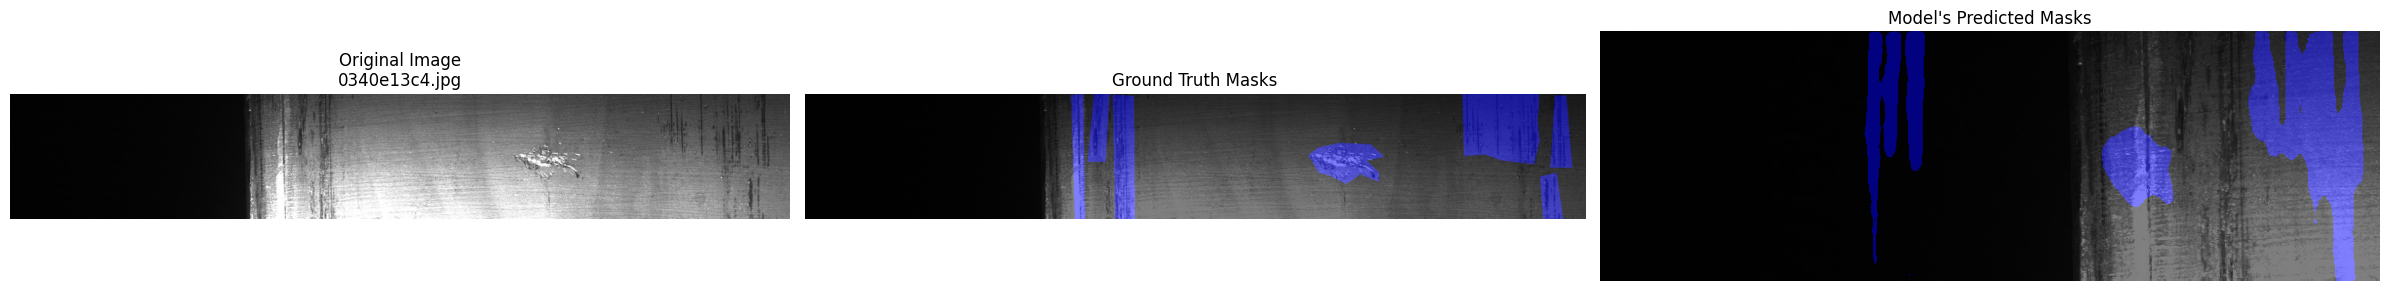

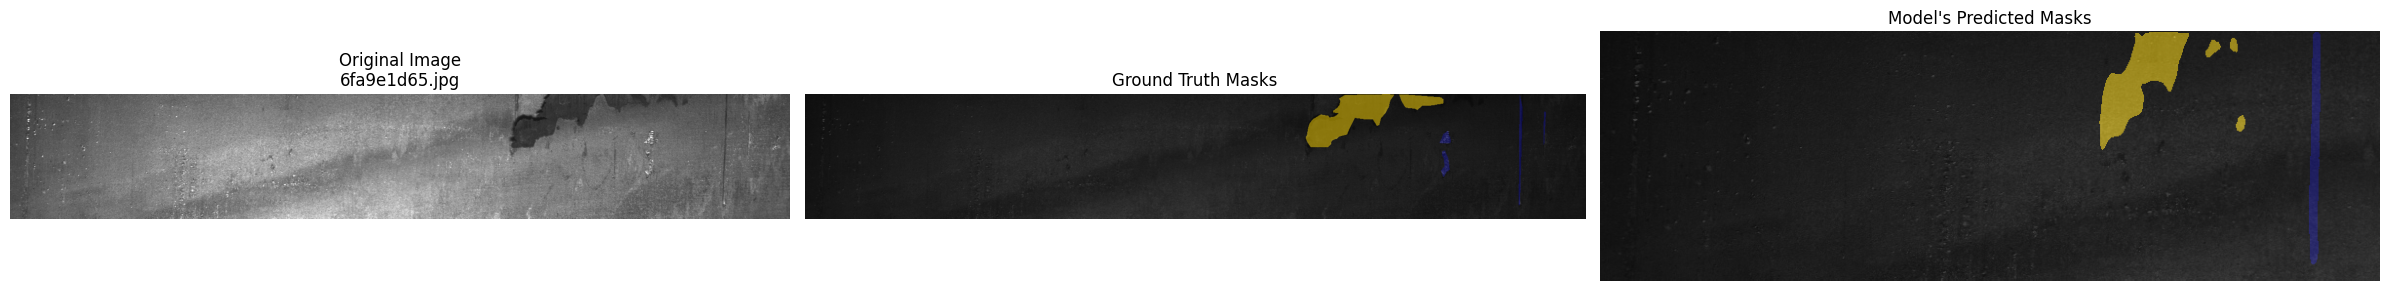

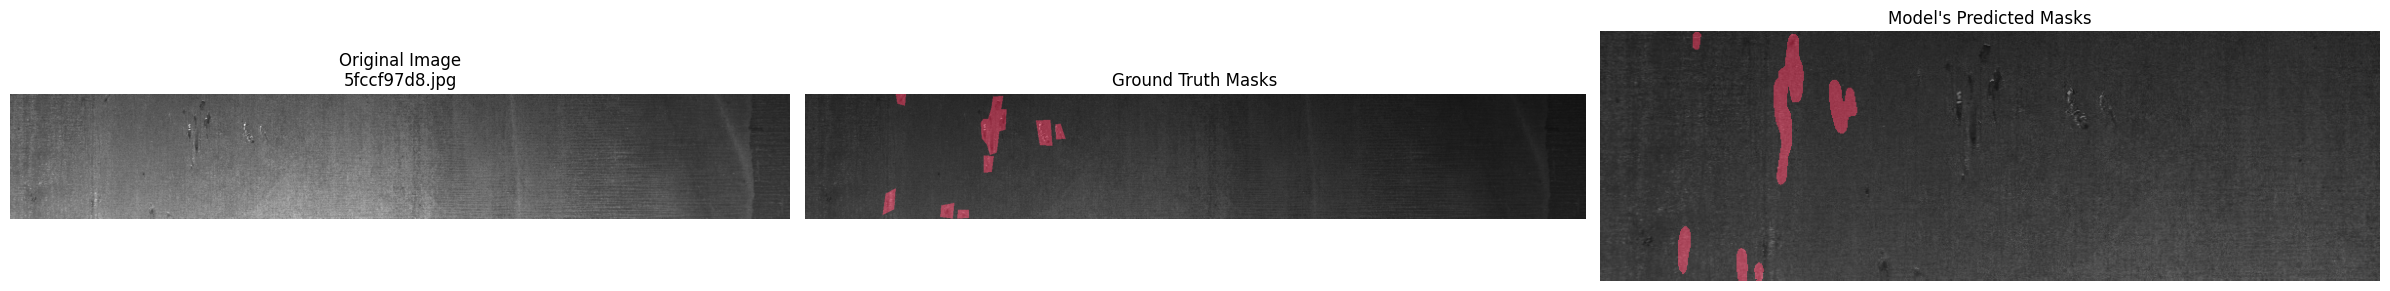

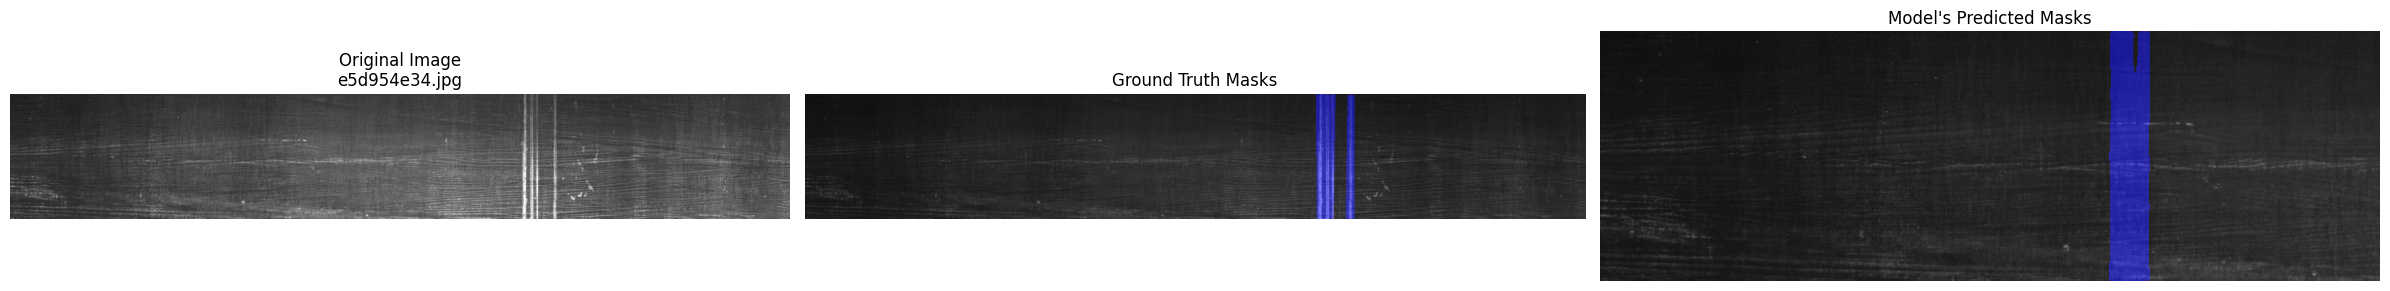

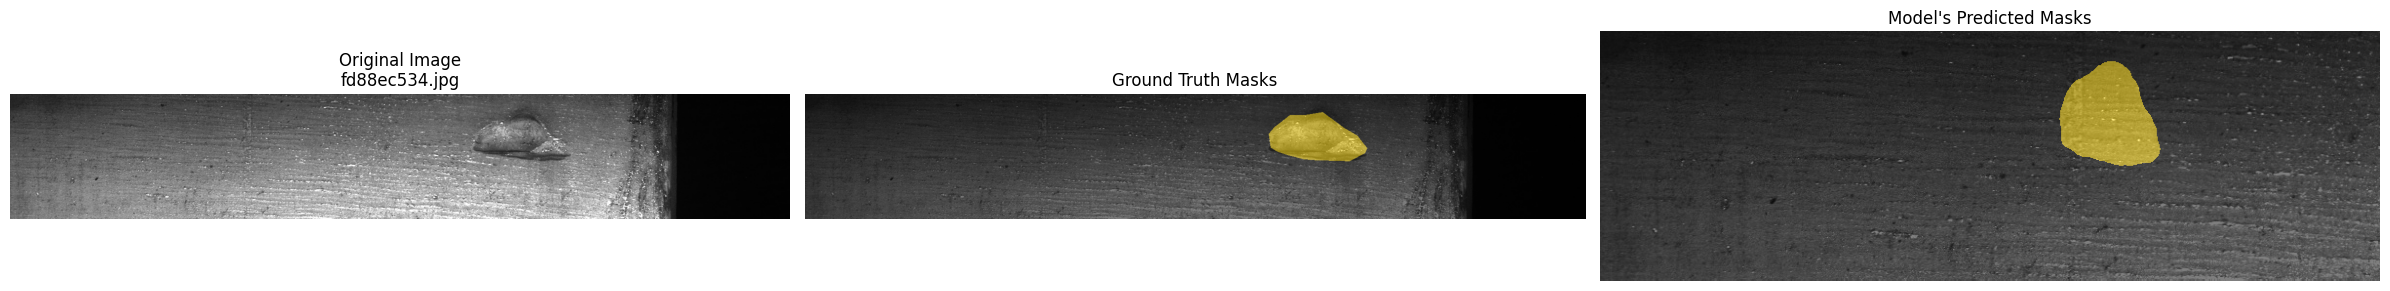

In [10]:
# --- 1. Load the Best Model ---
# The model architecture should still be in memory, but it's good practice
# to redefine it and load the weights to ensure we're using the best version.

MODEL_SAVE_PATH = "best_model_advanced.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define the model architecture
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None, # We are loading our own weights, not from imagenet
    in_channels=3,
    classes=4,
).to(DEVICE)

print(f"Loading best trained model from: {MODEL_SAVE_PATH}")
# Load the state dictionary from the saved file
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
# Set the model to evaluation mode (this is important!)
model.eval()

print("Model loaded successfully.")


# --- 2. Prediction and Visualization Function ---

def show_prediction(image_id, model, transforms, df_pivoted, device):
    # Load the original image for display
    img_path = os.path.join(TRAIN_IMG_DIR, image_id)
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Get the ground truth masks using our helper function
    true_masks = build_masks(image_id, df_pivoted)
    
    # Prepare the image for the model using the validation transforms
    transformed = transforms(image=original_image)
    input_image = transformed['image'].unsqueeze(0).to(device) # Add batch dimension and send to GPU
    
    # Get model prediction
    with torch.no_grad():
        pred_logits = model(input_image)
    
    # Post-process the prediction
    # Apply a sigmoid activation to get probabilities (0-1 range)
    pred_probs = torch.sigmoid(pred_logits)
    # Threshold the probabilities at 0.5 to get binary masks
    pred_masks = (pred_probs > 0.5).cpu().numpy().squeeze()
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Plot 1: Original Image
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image\n{image_id}")
    axes[0].axis('off')
    
    # Plot 2: Ground Truth
    axes[1].imshow(original_image)
    colors = [(220, 20, 60), (60, 179, 113), (0, 0, 255), (255, 215, 0)]
    for i in range(4):
        if true_masks[:, :, i].sum() > 0:
            overlay = np.dstack([true_masks[:, :, i] * color for color in colors[i]])
            axes[1].imshow(overlay, alpha=0.5)
    axes[1].set_title("Ground Truth Masks")
    axes[1].axis('off')
    
    # Plot 3: Model Prediction
    axes[2].imshow(original_image)
    for i in range(4):
        if pred_masks[i, :, :].sum() > 0:
            overlay = np.dstack([pred_masks[i, :, :] * color for color in colors[i]])
            axes[2].imshow(overlay, alpha=0.5)
    axes[2].set_title("Model's Predicted Masks")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 3. Run Predictions on Validation Samples ---
# We use val_transforms because we want to see how the model performs on clean, un-augmented images.
print("\n--- Visualizing predictions on validation set samples ---")
# Take 5 random samples from our validation dataframe to get a good overview
for i in val_df.sample(5, random_state=42).index:
    sample_row = val_df.loc[i]
    image_id = sample_row['ImageId']
    
    show_prediction(image_id, model, val_transforms, df_pivot, DEVICE)